In [776]:
import math
import numpy as np
import pandas as pd
import scipy.stats as si
import seaborn as sns

In [787]:
### parameters 
S0 = 100
K = 98
T = [0,0.25,0.5,0.75,1]
r = 0.0
delta = 0.02
mcpath = 100000
n = len(T)
np.random.seed(420) 

## PART A

In [788]:
n = len(T) # number of periods
sigma = 0.23 # Constant sigma 
dt = 1/4 # Constat time interval
S = np.zeros((mcpath,n)) 
for i in range(0,mcpath):
    t = 0 
    W = 0 
    C=np.ones(5)
    for j in range(0,n):
        if j==0:
            C[j]=100
        else:
            W = np.random.normal(0,np.sqrt(dt))
            C[j]=np.exp((r-delta-0.5*sigma**2)*dt+sigma*W)
        S[i,j] = np.prod(C) # price path

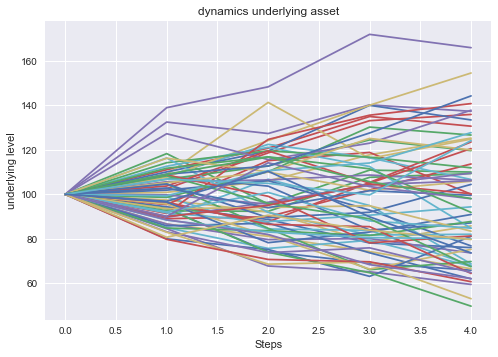

In [789]:
sdff=pd.DataFrame(S)
import matplotlib.pyplot as plt

plt.style.use('seaborn')

plt.plot(sdff.T.loc[:,0:1000:15])
plt.grid(True)
plt.title('dynamics underlying asset')
plt.xlabel('Steps')
plt.ylabel('underlying level')
plt.show()

In [790]:
# Compute A for t1 t2 t3 t4
A = np.zeros((mcpath,n))
A[:,1] = S[:,1]
A[:,2] = (S[:,1] + S[:,2])/2
A[:,3] = (S[:,1] + S[:,2] + S[:,3])/3
A[:,4] = (S[:,1] + S[:,2] + S[:,3] + S[:,4])/4

In [791]:
## define function for the intrinsic value
def intr(a):
    res = np.array([])
    for k in range(0,len(a)):
        if a[k] > 0:
            res = np.append(res,a[k]) 
        else:
            res = np.append(res,0)
    return res

In [792]:
 C = np.zeros((mcpath,n))
C[:,n-1] = intr(A[:,n-1]-K) # intrinsic value at the last period
for i in range(1,n):
    X = np.array([np.ones(mcpath),S[:,n-1-i],S[:,n-1-i]**2,S[:,n-1-i]**3,A[:,n-1-i],A[:,n-1-i]**2,A[:,n-1-i]**3]).T # variables on which 
    Y = np.sum(C,axis = 1) # cashflows received if not exercised 
    beta = np.dot(np.linalg.pinv(np.dot(X.T,X)),np.dot(X.T,Y)) # beta coefficients 
    Y_reg = np.dot(X,beta) # continuation value
    stop = intr(A[:,n-1-i]-K) > Y_reg # determing optimal stopping points
    C[:,n-1-i] = intr(A[:,n-1-i]-K)*stop # assign optimal stopping values to the cash flows
    for j in range(0,mcpath):
        if (stop[j] == True):  
            if (C[j,n-i] > 0):
                C[j,n-i:n] = 0 # delate cashflows after optimal strike
p=np.amax(C, 1) # when is never optimal to exrcise before maturity continuation value                         increasing overtime, hence optimal exercise at the last maturity

In [793]:
price=sum(p.T)/mcpath# price using LSMC with constant volatility.
price

7.067443990946188

In [794]:
dff=pd.DataFrame(p.T)
dff.describe()# summary statistic of the LSMC 

,0
count,100000.000000
mean,7.067444
std,10.344693
min,0.000000
25%,0.000000
50%,0.362104
75%,11.714036
max,92.959051


Text(0.5, 0, 'price')

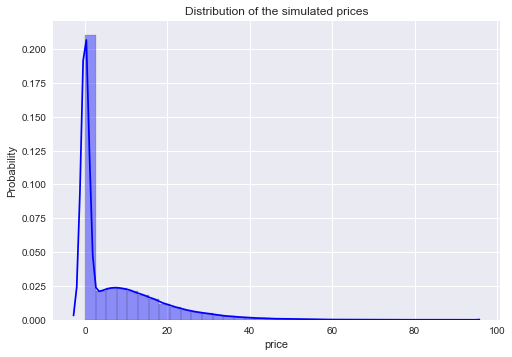

In [814]:
ax=sns.distplot(dff[0], hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
ax.set_title("Distribution of the simulated prices")
ax.set_ylabel('Probability')
ax.set_xlabel('price')

In [796]:
## BSM price of an European Call which is the lower boundary of the price of an american       call
def bs(S, K, T, r, q, sigma):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call 
bs(S0, K, 1,r,delta, sigma)

8.983224650185882

## PART B

In [827]:
## import implied volatilites from problem set 5
ind= pd.read_csv('./strikes.csv',names=['s'])/2772.70 
mat=pd.read_csv('./maturities.csv')
v=list(mat.columns)
vol= pd.read_csv('./impv_total.csv',names=v)
vol.index=ind.s

In [798]:
localvol=vol.loc[K/S0] # get the implied volatiliets for our K/S0
localvol=pd.concat([pd.Series([0]), localvol])

In [799]:
localvol=localvol.iloc[0:localvol.index.get_loc('1')+1] # consider volatility upto T=1

In [800]:
xp=[float(i) for i in localvol.index]
d=np.arange(0, 13, 1)/12
d=d.tolist()
localvolint=np.interp(d, xp, localvol) #interpolate local volatilities so to have montlhy                                          periods

In [822]:
np.std(localvolint[1:])

0.0017893173924356854

In [801]:
nl=len(localvolint) 
S = np.zeros((mcpath,nl))
for i in range(0,mcpath):
    t = 0 
    W = 0 
    C=np.ones(nl)
    j=0
    dtl=1/12
    for j in range(0,nl):
        if j==0:
            C[j]=100
        else:
            W = np.random.normal(0,np.sqrt(dtl))
            C[j]=np.exp((r-delta-0.5*localvolint[j]**2)*dtl+localvolint[j]*W)
        S[i,j] = np.prod(C) # generate underlying paths

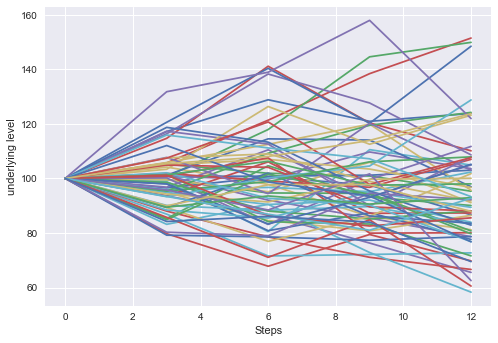

In [804]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')

 
plt.plot(sdf.T.loc[:,0:1000:15])
plt.grid(True)
plt.xlabel('Steps')
plt.ylabel('underlying level')
plt.show()

In [802]:
sdf=pd.DataFrame(S)
sdf=sdf.loc[:,0::3]
Sl=sdf.to_numpy() # select the price at 3m 6m 9m 12m 

In [803]:
# Compute A for t1 t2 t3 t4
Al = np.zeros((mcpath,n))
Al[:,1] = Sl[:,1]
Al[:,2] = (Sl[:,1] + Sl[:,2])/2
Al[:,3] = (Sl[:,1] + Sl[:,2] + Sl[:,3])/3
Al[:,4] = (Sl[:,1] + Sl[:,2] + Sl[:,3] + Sl[:,4])/4

In [805]:
p2=np.zeros((mcpath,1))
Cl = np.zeros((mcpath,n))# always possible to exercise in 5 periods
Cl[:,n-1] = intr(Al[:,n-1]-K) # intrinsic value at the last period
for i in range(1,5):
    X = np.array([np.ones(mcpath),Sl[:,n-1-i],Sl[:,n-1-i]**2,Sl[:,n-1-i]**3,Al[:,n-1-i],Al[:,n-1-i]**2,Al[:,n-1-i]**3]).T # variables on which regression for countinuation value is                                    run
    Y = np.sum(Cl,axis = 1) # future cashflows received if not exercised 
    beta = np.dot(np.linalg.pinv(np.dot(X.T,X)),np.dot(X.T,Y)) # beta coefficients 
    Y_reg = np.dot(X,beta) # continuation value
    stop = intr(Al[:,n-1-i]-K) > Y_reg # determing optimal stopping points
    Cl[:,n-1-i] = intr(Al[:,n-1-i]-K)*stop # assign optimal stopping values to the cash flows
    if (stop[j] == True):  
            if (Cl[j,n-1-i] > 0):
                Cl[j,n-i:n] = 0 # delate cashflows after optimal strike
                
p2=np.amax(Cl, 1)

In [806]:
price=sum(p2.T)/mcpath
price

6.99295203173467

In [807]:
df=pd.DataFrame(p2.T)
df.describe()

,0
count,100000.000000
mean,6.992952
std,10.569438
min,0.000000
25%,0.000000
50%,0.000000
75%,11.492476
max,111.730339


Text(0.5, 0, 'price')

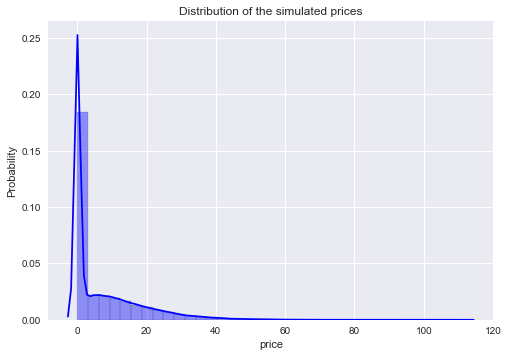

In [815]:
ax=sns.distplot(df[0], hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
ax.set_title("Distribution of the simulated prices")
ax.set_ylabel('Probability')
ax.set_xlabel('price')

In [809]:
from scipy import stats
t_check=stats.ttest_ind(p,p2,equal_var=False)
t_check
alpha=0.05
if(t_check[1]<alpha):
    print('price determined with constant volatility statistically different from the price determined with implied volatility ')
else:
   print(' we cannot reject that price determined with constant volatility statistically is equal to the price determined with implied volatility')

 we cannot reject that price determined with constant volatility statistically is eqaul to the price determined with implied volatility
